
```
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification")

In [1]:

import torch  # Main PyTorch Library
from pandas.conftest import axis_1

from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import DataLoader,Dataset
from torchvision import models
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

device = "cuda" if torch.cuda.is_available() else "cpu"  # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)

Device available:  cuda


In [2]:
train_df = pd.read_csv("archive/train.csv")
val_df = pd.read_csv("archive/val.csv")

In [3]:
train_df

,image:FILE,category
0,train/healthy/healthy_train.98.jpg,0
1,train/healthy/healthy_train.148.jpg,0
2,train/healthy/healthy_train.306.jpg,0
3,train/healthy/healthy_train.305.jpg,0
4,train/healthy/healthy_train.40.jpg,0
...,...,...
1029,train/bean_rust/bean_rust_train.29.jpg,2
1030,train/bean_rust/bean_rust_train.311.jpg,2
1031,train/bean_rust/bean_rust_train.336.jpg,2
1032,train/bean_rust/bean_rust_train.329.jpg,2


In [4]:
print(val_df.shape)
print(train_df.shape)


(133, 2)
(1034, 2)


In [5]:
print(train_df["category"].value_counts())

category
2    348
1    345
0    341
Name: count, dtype: int64


In [6]:
#object to pre-process all images
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
])



In [7]:
class CustomImageDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform
        self.labels = torch.tensor(df["category"]).to(device)

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx,0]
        label = self.labels[idx]
        image = Image.open(img_path)
        if self.transform:
            image = (self.transform(image)/255.0).to(device)

        return image, label









In [8]:
train_dataset = CustomImageDataset(train_df, transform=transform)
val_dataset = CustomImageDataset(val_df, transform=transform)


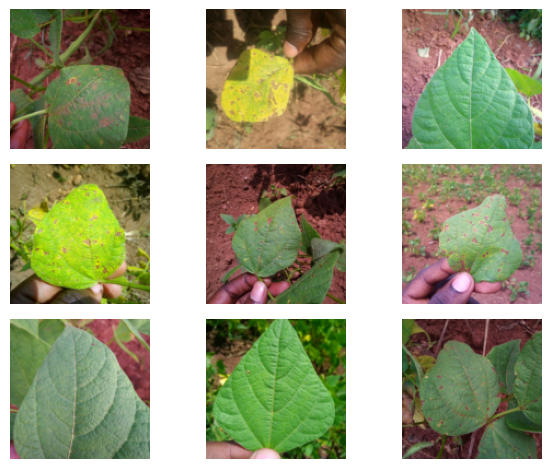

In [9]:

n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)
for row in range(n_rows):
    for col in range(n_cols):
        image = train_dataset[np.random.randint(0,train_dataset.__len__())][0].cpu()
        axarr[row, col].imshow((image*255).squeeze().permute(1,2,0))
        axarr[row, col].axis('off')

plt.tight_layout()
plt.show()

In [10]:
LR = 1e-3
BATCH_SIZE = 4
EPOCHS = 15


In [11]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
for x, y in train_loader:
    print(x)
    print("---------------------------------------")
    print(y)
    break

tensor([[[[9.9962e-04, 1.5686e-03, 1.1226e-03,  ..., 8.3045e-04,
           9.2272e-04, 1.2149e-03],
          [1.0304e-03, 1.5071e-03, 1.2918e-03,  ..., 9.9962e-04,
           8.9196e-04, 1.1995e-03],
          [1.0919e-03, 1.1688e-03, 1.0611e-03,  ..., 1.1380e-03,
           1.0150e-03, 1.1995e-03],
          ...,
          [1.0765e-03, 1.2303e-03, 1.1226e-03,  ..., 1.0150e-03,
           9.8424e-04, 8.3045e-04],
          [1.1226e-03, 1.0765e-03, 8.9196e-04,  ..., 9.5348e-04,
           9.0734e-04, 8.7659e-04],
          [1.0150e-03, 1.1995e-03, 1.0919e-03,  ..., 9.2272e-04,
           8.7659e-04, 8.7659e-04]],

         [[8.3045e-04, 1.4610e-03, 9.9962e-04,  ..., 2.3376e-03,
           2.5221e-03, 2.7528e-03],
          [8.3045e-04, 1.3226e-03, 1.1073e-03,  ..., 2.5375e-03,
           2.4452e-03, 2.7220e-03],
          [9.2272e-04, 9.6886e-04, 8.4583e-04,  ..., 2.2299e-03,
           2.0915e-03, 2.1992e-03],
          ...,
          [2.7220e-03, 2.8758e-03, 2.7989e-03,  ..., 2.4760

In [13]:
googlenet_model = models.googlenet( weights='DEFAULT')

In [14]:
vit  = models.vit_b_16(weights='DEFAULT')


In [15]:
vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [16]:
for param in googlenet_model.parameters():
    param.requires_grad = True


In [17]:
googlenet_model.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [18]:
num_classes = len(train_df["category"].unique())
num_classes

3

In [19]:
googlenet_model.fc = torch.nn.Linear(in_features=1024, out_features=num_classes)
googlenet_model.fc

Linear(in_features=1024, out_features=3, bias=True)

In [20]:
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [21]:


loss_fun = nn.CrossEntropyLoss()
optimizer = Adam(googlenet_model.parameters(), lr=LR)

total_loss_train_plot = []
total_acc_train_plot = []

for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0

  for (inputs, labels) in train_loader:
    optimizer.zero_grad()
    outputs = googlenet_model(inputs)
    train_loss = loss_fun(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}%')
  print()


Epoch 1/15, Train Loss: 2.5691 Train Accuracy 48.8395%

Epoch 2/15, Train Loss: 2.1777 Train Accuracy 63.2495%

Epoch 3/15, Train Loss: 2.0912 Train Accuracy 63.9265%

Epoch 4/15, Train Loss: 2.0579 Train Accuracy 65.087%

Epoch 5/15, Train Loss: 1.869 Train Accuracy 68.5687%

Epoch 6/15, Train Loss: 1.6893 Train Accuracy 73.2108%

Epoch 7/15, Train Loss: 1.6693 Train Accuracy 72.6306%

Epoch 8/15, Train Loss: 1.4579 Train Accuracy 77.6596%

Epoch 9/15, Train Loss: 1.3876 Train Accuracy 77.9497%

Epoch 10/15, Train Loss: 1.47 Train Accuracy 76.7892%

Epoch 11/15, Train Loss: 1.4187 Train Accuracy 77.0793%

Epoch 12/15, Train Loss: 1.3365 Train Accuracy 81.3346%

Epoch 13/15, Train Loss: 1.0678 Train Accuracy 83.7524%

Epoch 14/15, Train Loss: 1.1895 Train Accuracy 82.9787%

Epoch 15/15, Train Loss: 1.121 Train Accuracy 83.1721%



In [22]:

with torch.no_grad():
  total_loss_test = 0
  total_val_test = 0
  for indx, (input, labels) in enumerate(val_loader):

    prediction = googlenet_model(input)

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    total_val_test += acc

print(f"Accuracy Score is: {round((total_val_test/val_dataset.__len__())*100, 2)}%")

Accuracy Score is: 81.2%


# Transfer learning

In [25]:
googlenet_model = models.googlenet( weights='DEFAULT')
for param in googlenet_model.parameters():
    param.requires_grad = False

googlenet_model.fc = torch.nn.Linear(in_features=1024, out_features=num_classes)
googlenet_model.fc.requires_grad = True
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [26]:


loss_fun = nn.CrossEntropyLoss()
optimizer = Adam(googlenet_model.parameters(), lr=LR)

total_loss_train_plot = []
total_acc_train_plot = []

for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0

  for (inputs, labels) in train_loader:
    optimizer.zero_grad()
    outputs = googlenet_model(inputs)
    train_loss = loss_fun(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}%')
  print()


Epoch 1/15, Train Loss: 2.6742 Train Accuracy 47.5822%

Epoch 2/15, Train Loss: 2.3512 Train Accuracy 58.2205%

Epoch 3/15, Train Loss: 2.2134 Train Accuracy 61.412%

Epoch 4/15, Train Loss: 2.2515 Train Accuracy 60.8317%

Epoch 5/15, Train Loss: 2.31 Train Accuracy 58.3172%

Epoch 6/15, Train Loss: 2.2592 Train Accuracy 59.5745%

Epoch 7/15, Train Loss: 2.2185 Train Accuracy 63.4429%

Epoch 8/15, Train Loss: 2.2407 Train Accuracy 60.1547%

Epoch 9/15, Train Loss: 2.2414 Train Accuracy 61.3153%

Epoch 10/15, Train Loss: 2.1253 Train Accuracy 62.1857%

Epoch 11/15, Train Loss: 2.3023 Train Accuracy 59.1876%

Epoch 12/15, Train Loss: 2.2244 Train Accuracy 62.9594%

Epoch 13/15, Train Loss: 2.1251 Train Accuracy 64.0232%

Epoch 14/15, Train Loss: 2.1172 Train Accuracy 61.412%

Epoch 15/15, Train Loss: 2.1096 Train Accuracy 63.0561%



In [27]:

with torch.no_grad():
  total_loss_test = 0
  total_val_test = 0
  for indx, (input, labels) in enumerate(val_loader):

    prediction = googlenet_model(input)

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    total_val_test += acc

print(f"Accuracy Score is: {round((total_val_test/val_dataset.__len__())*100, 2)}%")

Accuracy Score is: 63.16%


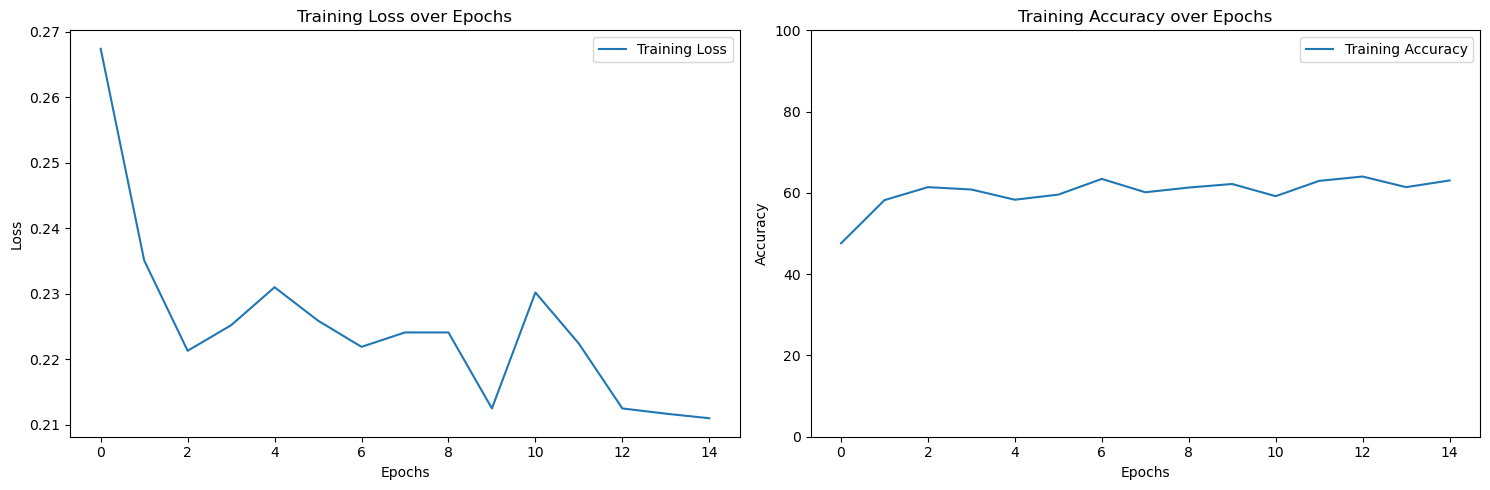

In [28]:

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].set_title('Training Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()